In [1]:
import pandas as pd
import jaydebeapi
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
url = "jdbc:IRIS://irisimlsvr:1972/USER"
driver = 'com.intersystems.jdbc.IRISDriver'
user = "SUPERUSER"
password = "SYS"
jarfile = "./intersystems-jdbc-3.1.0.jar"

conn = jaydebeapi.connect(driver, url, [user, password], jarfile)
curs = conn.cursor()

In [3]:
columns = "TimeReference,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Response"
df = pd.read_sql("SELECT top 1000 %s FROM SQLUser.CreditCard order by ID" % columns, conn)
display(df)

,TimeReference,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Response
0,394,-0.5531,1.6676,-0.0474,0.5142,0.5894,-0.6354,1.1266,-0.3119,0.0352,...,-0.0335,0.6877,-0.0767,0.0148,-0.5907,-0.4830,0.1377,-0.3349,1.55,0
1,406,-2.3122,1.9520,-1.6099,3.9979,-0.5222,-1.4265,-2.5374,1.3917,-2.7701,...,0.5172,-0.0350,-0.4652,0.3202,0.0445,0.1778,0.2611,-0.1433,0.00,1
2,406,-1.6450,-2.0908,1.5926,-1.3889,1.7329,-1.6311,-0.9229,0.0138,1.7608,...,0.2482,0.4155,0.2933,-0.4634,-0.4052,-0.9241,0.0066,0.0187,46.68,0
3,407,-0.9181,0.7985,1.7535,-0.5770,-0.5548,0.1195,1.0962,-0.1146,-0.2133,...,0.0507,0.2013,0.0236,0.1074,-0.4645,0.0049,-0.0680,0.0938,146.25,0
4,408,-2.9908,1.9330,0.4235,-2.0199,-0.1086,-0.2957,0.6297,-0.0450,2.4248,...,-0.5727,-0.3252,0.1543,-0.3315,0.2346,0.7601,0.9554,0.5365,7.30,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,34635,1.0716,0.1234,0.4999,1.3393,-0.1872,0.0334,0.0140,0.0967,-0.0265,...,-0.0221,0.1075,-0.0695,0.2407,0.6080,-0.3452,0.0347,0.0116,27.00,0
996,34635,-0.4385,0.8767,1.1958,-0.3857,0.5054,0.3561,0.4610,0.3136,-0.4911,...,-0.2117,-0.5802,-0.0986,-0.8479,-0.2116,0.1372,0.2721,0.0974,3.08,0
997,34636,-0.7554,1.2851,1.6526,1.5203,0.7006,0.1706,0.6981,0.2579,-1.0049,...,-0.0404,-0.0611,-0.3914,-0.1096,0.3492,-0.0754,0.0684,0.1051,0.76,0
998,34637,-1.9378,-0.4442,1.2730,3.0138,-0.7668,2.2268,2.5023,-0.4493,-0.2891,...,-0.5296,0.1258,0.4378,-0.2795,-0.2039,0.1457,0.5338,-0.4225,510.68,0


In [4]:
df = pd.read_sql('SELECT Response, Count(*) FROM SQLUser.CreditCard GROUP BY Response', conn)
display(df)

,Response,Aggregate_2
0,0,4853
1,1,492


<BarContainer object of 2 artists>

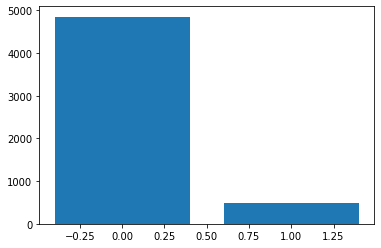

In [5]:
plt.bar(df['Response'], df['Aggregate_2'])

In [6]:
curs.execute(
    'CREATE OR REPLACE VIEW SQLUser.CreditCardBalanced AS \
     SELECT TOP 200 %s FROM SQLUser.CreditCard WHERE Response = 1 \
     UNION \
     SELECT TOP 200 %s FROM SQLUser.CreditCard WHERE Response = 0' % (columns, columns))

In [7]:
df = pd.read_sql('SELECT Response, Count(*) FROM SQLUser.CreditCardBalanced GROUP BY Response', conn)
display(df)

,Response,Aggregate_2
0,0,196
1,1,200


<BarContainer object of 2 artists>

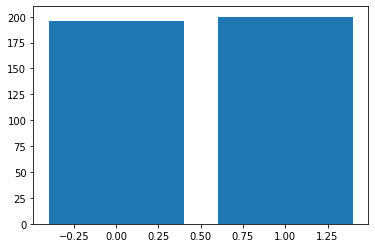

In [8]:
plt.bar(df['Response'], df['Aggregate_2'])

In [9]:
curs.execute(
    'CREATE OR REPLACE VIEW SQLUser.CreditCardTrain AS \
     SELECT TOP 75 %s FROM SQLUser.CreditCardBalanced WHERE Response = 1 \
     UNION \
     SELECT TOP 75 %s FROM SQLUser.CreditCardBalanced WHERE Response = 0' % (columns, columns))

curs.execute(
    'CREATE OR REPLACE VIEW SQLUser.CreditCardTest AS \
     SELECT TOP 25 %s FROM SQLUser.CreditCardBalanced WHERE Response = 1 \
     UNION \
     SELECT TOP 25 %s FROM SQLUser.CreditCardBalanced WHERE Response = 0' % (columns, columns))

In [10]:
try:
    curs.execute("DROP MODEL CredCardFraudModel")
except Exception as e:
    print(e)
    print('No previous model detected')
curs.execute("CREATE MODEL CredCardFraudModel PREDICTING (Response) FROM SQLUser.CreditCardTrain")
print('Training model (this could take a while)...')
curs.execute("TRAIN MODEL CredCardFraudModel")
print('Model trained')

Training model (this could take a while)...
Model trained


In [11]:
display(pd.read_sql("SELECT * FROM INFORMATION_SCHEMA.ML_TRAINED_MODELS", conn))

,MODEL_NAME,TRAINED_MODEL_NAME,PROVIDER,TRAINED_TIMESTAMP,MODEL_TYPE,MODEL_INFO
0,CredCardFraudModel,CredCardFraudModel_t1,AutoML,2020-11-15 07:44:37.380000,classification,"ModelType:TensorFlow Neural Network, Package:T..."


In [12]:
df = pd.read_sql("SELECT PROBABILITY(CredCardFraudModel FOR 1) AS FraudProbability, \
                  PREDICT(CredCardFraudModel) AS PredictedResponse, \
                  Response AS ActualResponse FROM SQLUser.CreditCardTest", conn)

In [13]:
df.head()

,FraudProbability,PredictedResponse,ActualResponse
0,0.808688,1,1
1,0.608943,1,1
2,0.823975,1,1
3,0.996335,1,1
4,0.982022,1,1


In [14]:
df.tail()

,FraudProbability,PredictedResponse,ActualResponse
45,0.023673,0,0
46,0.004597,0,0
47,0.002258,0,0
48,0.003026,0,0
49,0.001842,0,0


In [15]:
curs.execute("VALIDATE MODEL CredCardFraudModel FROM SQLUser.CreditCardTest")
df = pd\
    .read_sql("SELECT * FROM INFORMATION_SCHEMA.ML_VALIDATION_METRICS", conn)\
    .pivot(index='VALIDATION_RUN_NAME', columns='METRIC_NAME', values='METRIC_VALUE')
display(df)

METRIC_NAME,Accuracy,F-Measure,Precision,Recall
VALIDATION_RUN_NAME,,,,
CredCardFraudModel_t1_v1,1.0,1.0,1.0,1.0


In [16]:
curs.close()
conn.close()